## Unmixing over transect sites


In [1]:
import joblib

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from scipy.optimize import nnls

### Calculate transect fractions

In [2]:
# Read the CSV file into a DataFrame
df = pd.read_csv('s2_fc/star_transects.csv')

df = df[df.obs_time>'2022-07-01T00:00:00']

In [3]:
def fractionalCoverSatView(df):
    """
    Calculate fractional cover as viewed from a satellite based on intercept data from a DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing the necessary columns:
        - 'num_points', 'unoccluded', 'over_b', 'over_d', 'over_g', 'crn',
          'mid_b', 'mid_g', 'mid_d', 'dead', 'litter', 'crust', 'dist',
          'rock', 'green', 'crypto'.

    Returns:
    tuple of np.ndarray: Six NumPy arrays, each representing one of the calculated cover metrics.
    """
    
    totalPVCover_list = []
    totalNPVCover_list = []
    totalBareCover_list = []
    totalCryptoCover_list = []
    satPersistentGreen_list = []
    persistentNPVFraction_list = []

    for _, row in df.iterrows():
        nTotal = row['num_points']
        nUnoccluded = row['unoccluded']
        
        # Canopy Layer
        nCanopyBranch = row['over_b'] * nTotal / 100.0
        nCanopyDead = row['over_d'] * nTotal / 100.0
        nCanopyGreen = row['over_g'] * nTotal / 100.0
        
        # Midstory Layer
        nMidBranch = row['mid_b'] * nTotal / 100.0
        nMidGreen = row['mid_g'] * nTotal / 100.0
        nMidDead = row['mid_d'] * nTotal / 100.0
        
        # Ground Layer
        nGroundDeadLitter = (row['dead'] + row['litter']) * nUnoccluded / 100.0
        nGroundCrustDistRock = (row['crust'] + row['dist'] + row['rock']) * nUnoccluded / 100.0
        nGroundGreen = row['green'] * nUnoccluded / 100.0
        nGroundCrypto = row['crypto'] * nUnoccluded / 100.0
        
        # Calculations
        canopyFoliageProjectiveCover = nCanopyGreen / (nTotal - nCanopyBranch)
        canopyDeadProjectiveCover = nCanopyDead / (nTotal - nCanopyBranch)
        canopyBranchProjectiveCover = nCanopyBranch / nTotal * (1.0 - canopyFoliageProjectiveCover - canopyDeadProjectiveCover)
        canopyPlantProjectiveCover = (nCanopyGreen+nCanopyDead + nCanopyBranch) / nTotal
        
        midFoliageProjectiveCover = nMidGreen / nTotal
        midDeadProjectiveCover = nMidDead / nTotal
        midBranchProjectiveCover = nMidBranch / nTotal
        midPlantProjectiveCover = (nMidGreen + nMidDead + nMidBranch) / nTotal
        
        satMidFoliageProjectiveCover = midFoliageProjectiveCover * (1 - canopyPlantProjectiveCover)
        satMidDeadProjectiveCover = midDeadProjectiveCover * (1 - canopyPlantProjectiveCover)
        satMidBranchProjectiveCover = midBranchProjectiveCover * (1 - canopyPlantProjectiveCover)
        
        groundPVCover = nGroundGreen / nUnoccluded
        groundNPVCover = nGroundDeadLitter / nUnoccluded
        groundBareCover = nGroundCrustDistRock / nUnoccluded
        groundCryptoCover = nGroundCrypto / nUnoccluded
        groundTotalCover = (nGroundGreen + nGroundDeadLitter + nGroundCrustDistRock) / nUnoccluded
        
        satGroundPVCover = groundPVCover * (1 - midPlantProjectiveCover) * (1 - canopyPlantProjectiveCover)
        satGroundNPVCover = groundNPVCover * ( 1- midPlantProjectiveCover) * (1 - canopyPlantProjectiveCover)
        satGroundBareCover = groundBareCover * (1 - midPlantProjectiveCover) * (1 - canopyPlantProjectiveCover)
        satGroundCryptoCover = groundCryptoCover * (1 - midPlantProjectiveCover) * (1 - canopyPlantProjectiveCover)
        
        totalPVCover = canopyFoliageProjectiveCover + satMidFoliageProjectiveCover + satGroundPVCover
        totalNPVCover = (canopyDeadProjectiveCover + canopyBranchProjectiveCover +
                         satMidDeadProjectiveCover + satMidBranchProjectiveCover + satGroundNPVCover)
        totalBareCover = satGroundBareCover
        totalCryptoCover = satGroundCryptoCover
        
        satPersistentGreen = canopyFoliageProjectiveCover + satMidFoliageProjectiveCover
        persistentNPVFraction = (canopyDeadProjectiveCover + canopyBranchProjectiveCover +
                                 satMidDeadProjectiveCover + satMidBranchProjectiveCover)

        totalPVCover_list.append(totalPVCover)
        totalNPVCover_list.append(totalNPVCover)
        totalBareCover_list.append(totalBareCover)
        totalCryptoCover_list.append(totalCryptoCover)
        satPersistentGreen_list.append(satPersistentGreen)
        persistentNPVFraction_list.append(persistentNPVFraction)

    df['totalPVCover'] = np.array(totalPVCover_list)
    df['totalNPVCover'] = np.array(totalNPVCover_list)
    df['totalBareCover'] = np.array(totalBareCover_list)
    df['totalCryptoCover'] = np.array(totalCryptoCover_list)
    df['satPersistentGreen'] = np.array(satPersistentGreen_list)
    df['persistentNPVFraction'] = np.array(persistentNPVFraction_list)
    return (
        np.array(totalPVCover_list),
        np.array(totalNPVCover_list),
        np.array(totalBareCover_list),
        np.array(totalCryptoCover_list),
        np.array(satPersistentGreen_list),
        np.array(persistentNPVFraction_list),
    )

# Calculate fractional cover as viewed from a satellite based on intercept data   
totalPVCover,totalNPVCover,totalBareCover,totalCryptoCover,satPersistentGreen,persistentNPVFraction = fractionalCoverSatView(df)

df_fc = df[['FID', 'ref_x', 'ref_y', 'obs_time', 'totalPVCover','totalNPVCover','totalBareCover','totalCryptoCover', 'satPersistentGreen', 'persistentNPVFraction']]


In [4]:
len(df_fc)

74

### Load saved EMIT spectra over transect

In [5]:
transect_spectra = joblib.load('transect_match/transect_emit_spectra_multiple.pkl')

In [6]:
# Define the valid wavelength ranges
ranges_exclude = [(0, 440), (1310, 1490), (1770, 2050), (2440, 2880)]
# Function to check if a wavelength is outside the valid ranges
def is_outside_range(wavelength, ranges):
    return not any(start <= wavelength <= end for start, end in ranges)

empty spectra -7138 (2023-03-13 20230318T062547)
empty spectra -7090 (2023-03-13 20230318T062547)
empty spectra -7088 (2023-03-13 20230318T062547)
empty spectra -71ca (2023-11-02 20231030T024114)


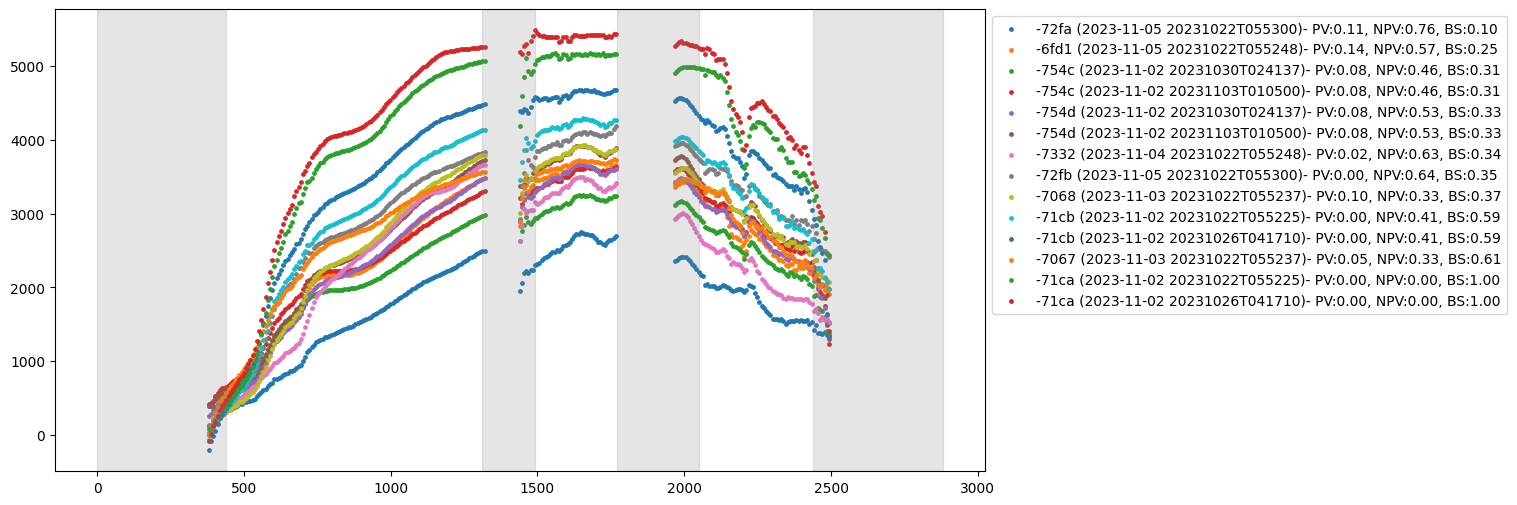

In [7]:
plt.figure(figsize=(12,6))

fids = []
dfs = []
bs_frac = []
emit_times = []

for key, df in transect_spectra.items():
    fid, itemid = key
    row =df_fc[df_fc['FID']==fid]
    fids.append(fid)
    dfs.append(df)
    bs_frac.append(row['totalBareCover'].values[0])
    emit_times.append(itemid.split('_')[4])

order = np.argsort(bs_frac)

for id in order:
    fid = fids[id]
    df = dfs[id]
    row =df_fc[df_fc['FID']==fid]

    # Get the indices of the bands that fall outside the ranges
    df_filtered = df#[[is_outside_range(round(wavelength), ranges_exclude) for wavelength in df.wavelengths]]
    df_filtered = df_filtered[~df_filtered.reflectance.isnull()]
    if len(df_filtered)==0: 
        print("empty spectra", f"{fid.split('_')[-1]} ({row['obs_time'].values[0][:10]} {emit_times[id]})")
    else:
        label = f"{fid.split('_')[-1]} ({row['obs_time'].values[0][:10]} {emit_times[id]})- PV:{row['totalPVCover'].values[0]:.2f}, NPV:{row['totalNPVCover'].values[0]:.2f}, BS:{row['totalBareCover'].values[0]:.2f}"
        plt.scatter(df_filtered.wavelengths, df_filtered.reflectance*10000., label=label, s=6)


for r in ranges_exclude: plt.axvspan(r[0], r[1], color='gray', alpha=0.2)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1));
    

### Unmixing using saved endmembers

In [41]:
# 4 soil plus other QHULL endmembers from VIC site
endmembers_df = pd.read_csv('unmixing/soil_4_and_qhull_3_endmembers.csv', index_col=0)
bare_green_dry = [[0,1,2,3], [4,5], [6]] # Bare, green, dry endmember mapping

# 4 soil plus other SMACC endmembers from VIC site
#endmembers_df = pd.read_csv('unmixing/soil_4_and_smacc_3_endmembers.csv', index_col=0)
#bare_green_dry = [[0,1,2,3], [4, 6], [5]] # Bare, green, dry endmember mapping


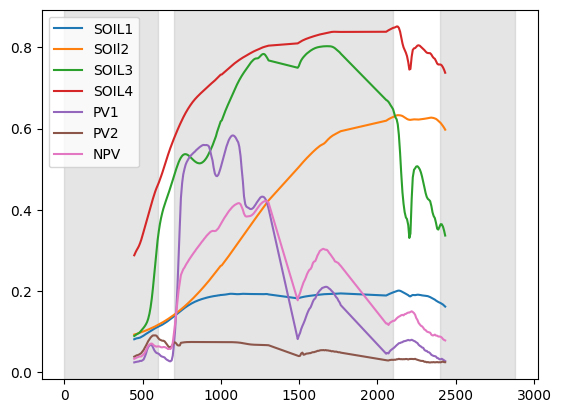

In [42]:
endmembers_df.plot();
for r in ranges_exclude: plt.axvspan(r[0], r[1], color='gray', alpha=0.2)

In [10]:
def unmix_nnls(nbar_transformed, endmembers, bare_green_dry):
    '''
    nbar_transformed has to be 2D (band, row)
    '''

    # Setup inputs, outputs, and other configurations
    sum_to_one = endmembers.shape[0]
    weighted_endmembers = np.vstack((endmembers.T, np.ones(endmembers.shape[0]) * sum_to_one))

    # Precompute ones array outside the loop
    ones_array = np.full((1, nbar_transformed.shape[1]), sum_to_one)

    # Combine weighted reflectance with ones_array using np.vstack
    weightedReflectance = np.vstack((nbar_transformed, ones_array))

    # Initialize fractions array with zeros
    fractions_nnls = np.zeros((weighted_endmembers.shape[1], nbar_transformed.shape[1]), dtype=np.float32)

    # Use vectorization where possible
    for i in range(weightedReflectance.shape[1]):
        fractions_nnls[:, i], _ = nnls(weighted_endmembers, weightedReflectance[:, i])
    
    # Reshape, clip, and convert to 8-bit data
    fractions = np.clip(np.rint(100.0 * fractions_nnls), 0, 200).astype('uint8')

    # Compute fractions for bare, green, dry vegetation
    fractions_bgd = np.zeros((3, nbar_transformed.shape[1]), dtype=np.uint8)
    fractions_bgd[0] = fractions[bare_green_dry[0]].sum(axis=0)
    fractions_bgd[1] = fractions[bare_green_dry[1]].sum(axis=0)
    fractions_bgd[2] = fractions[bare_green_dry[2]].sum(axis=0)

    #print("Average difference to total of 100%", (fractions.sum(axis=0)-100.).mean())

    return fractions_nnls, fractions, fractions_bgd

In [43]:
endmembers_df.head()

,SOIL1,SOIl2,SOIL3,SOIL4,PV1,PV2,NPV
447,0.081134,0.092678,0.089177,0.287949,0.024181,0.038365,0.032976
455,0.082487,0.093749,0.091337,0.294940,0.025051,0.039845,0.034536
462,0.083446,0.094290,0.093216,0.300366,0.025664,0.041536,0.035997
470,0.083836,0.095489,0.095018,0.305687,0.026091,0.041990,0.037265
477,0.084513,0.096350,0.096539,0.310974,0.026526,0.043329,0.038390


Only using SWIR

* Bare: RMSE 0.17, MAE 0.12
* PV: RMSE 0.05, MAE 0.03
* NPV: RMSE 0.19, MAE 0.17

NIR + SWIR
* Bare: RMSE 0.16, MAE 0.13
* PV: RMSE 0.05, MAE 0.04
* NPV: RMSE 0.18, MAE 0.15

fractions [ 0 13 11  7  0  0 69]
fractions [ 0 13 10 11  0  0 66]
fractions [20  4  9  9  0  0 58]
fractions [19  5  9 13  0  0 54]
fractions [ 0 11 11  0  0  0 77]
fractions [ 0  3  6 25  0  0 66]
fractions [ 0  9  4  0  0  4 83]
fractions [ 0  3 15 20  0  0 62]
fractions [ 0  4 13 27  0  0 55]
fractions [ 0 10 34 19  0  0 37]
fractions [16  8 30 25  0  0 22]


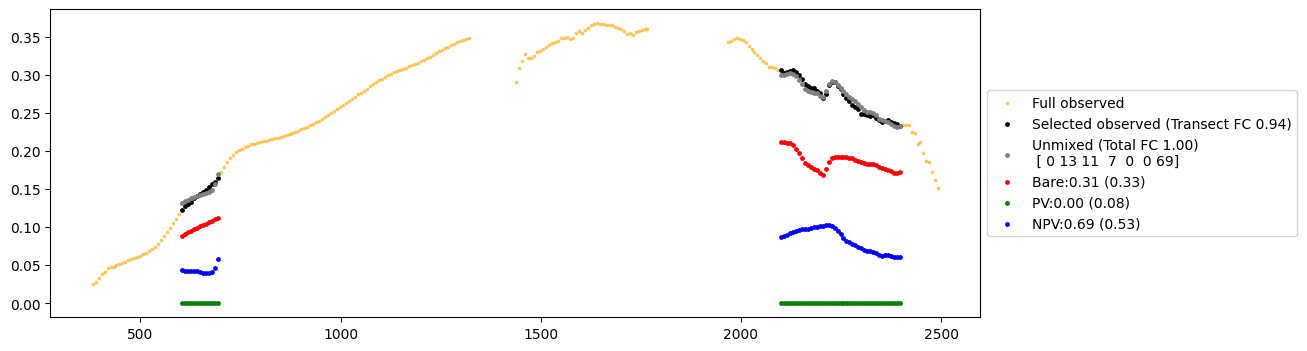

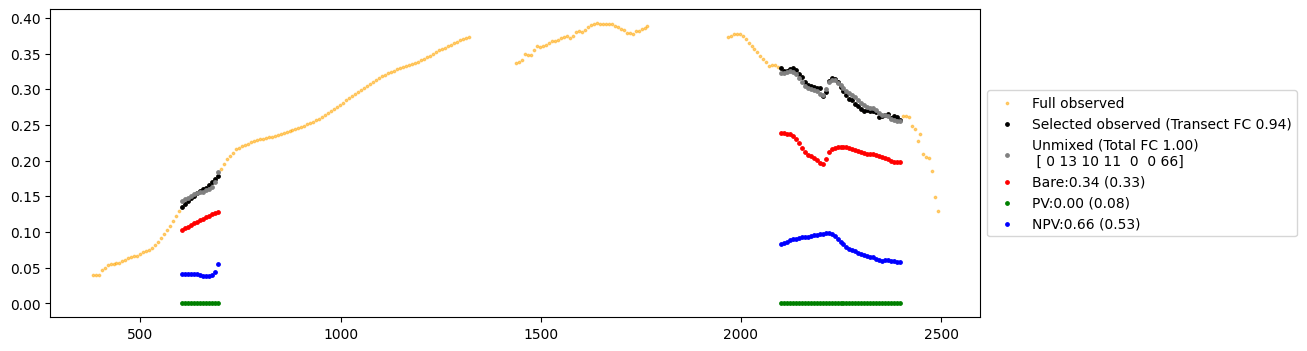

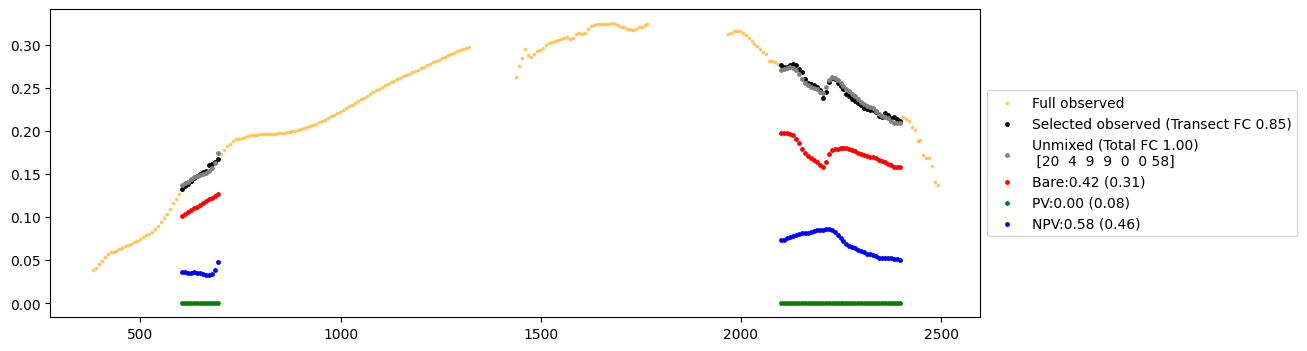

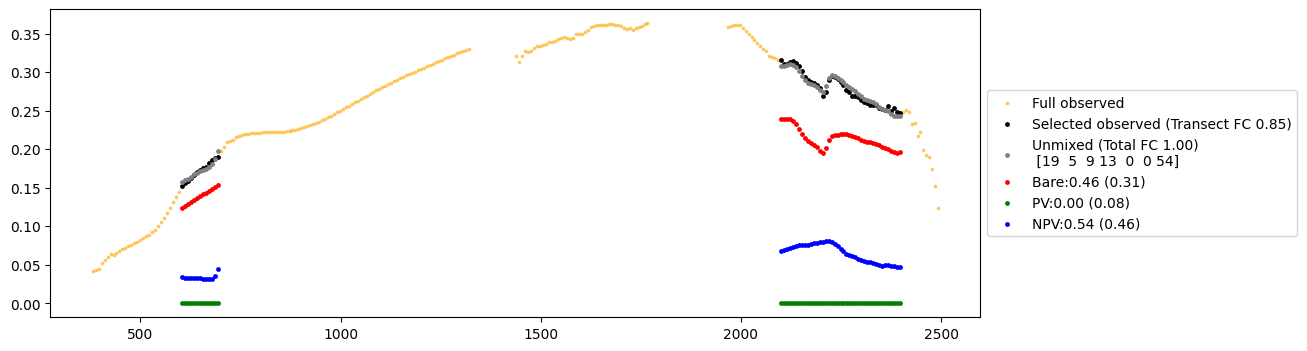

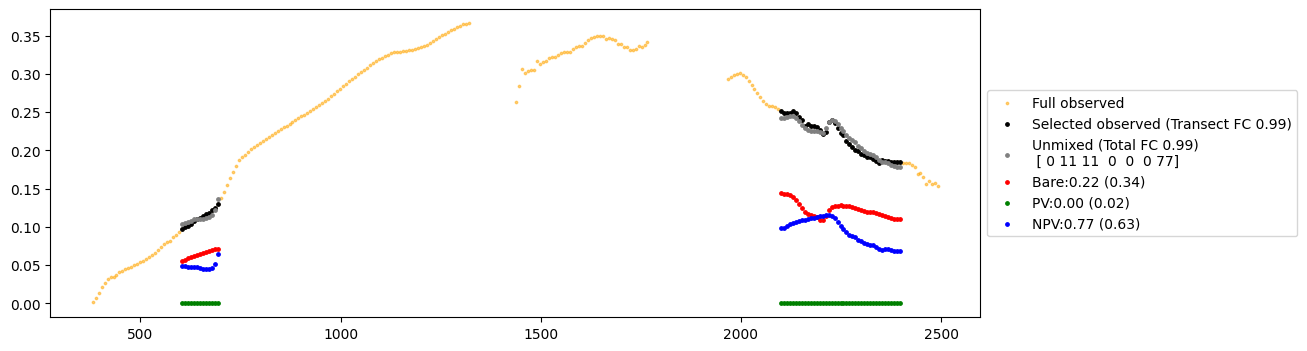

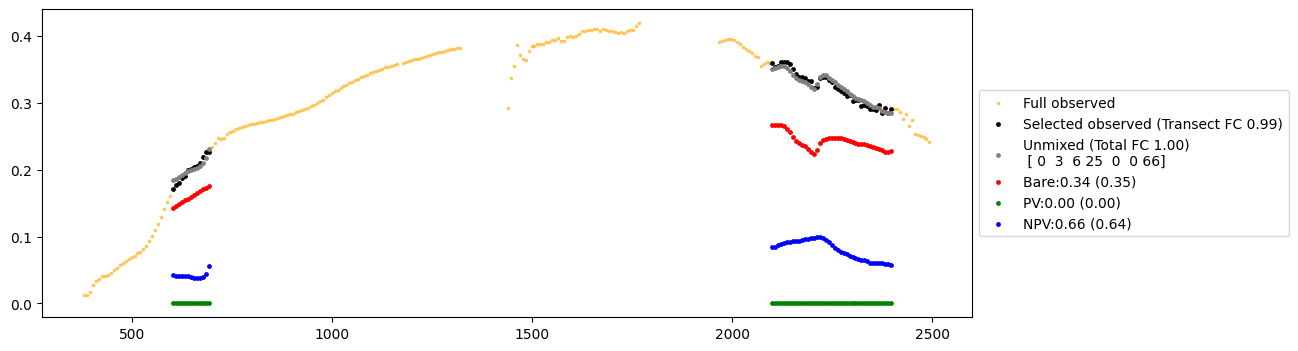

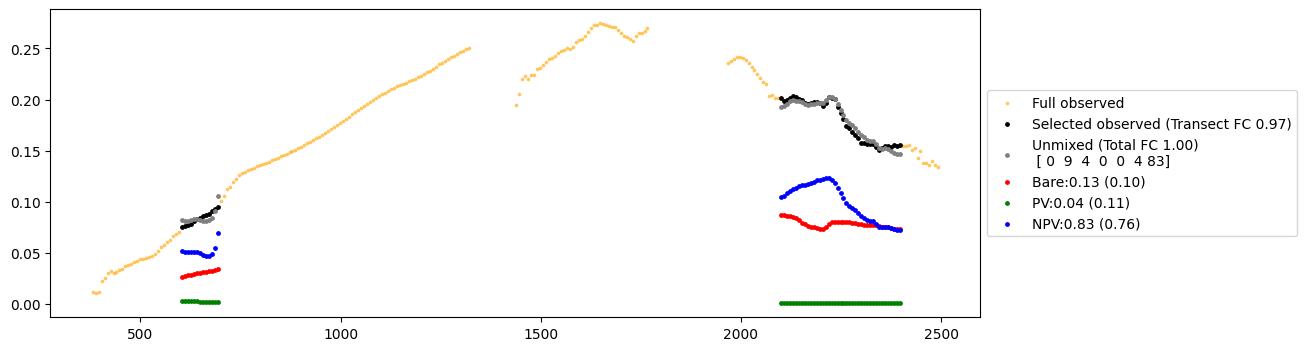

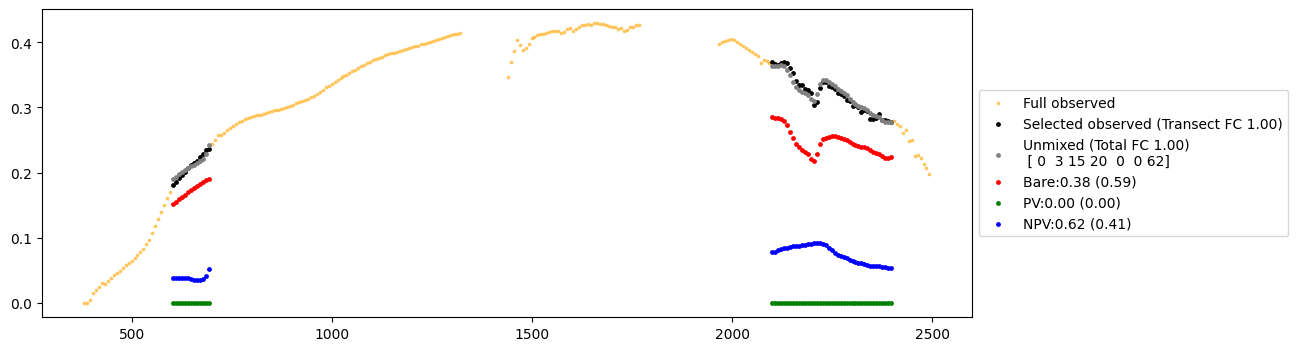

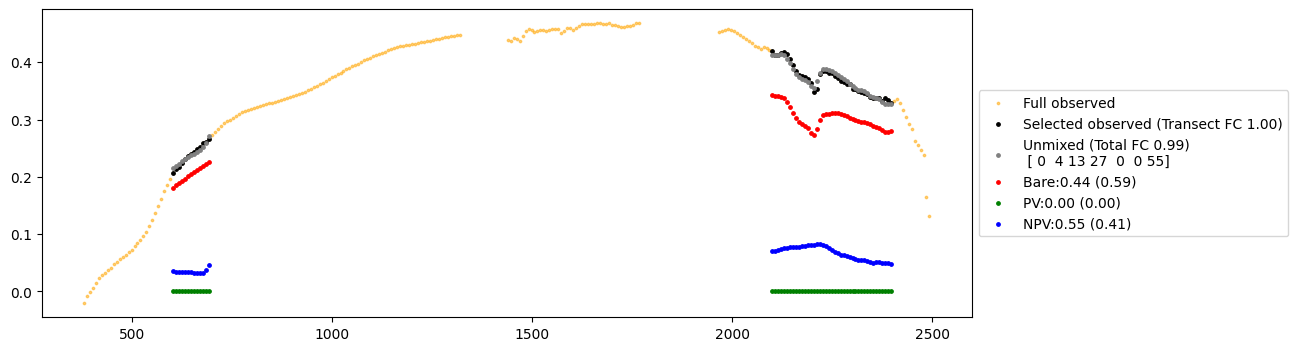

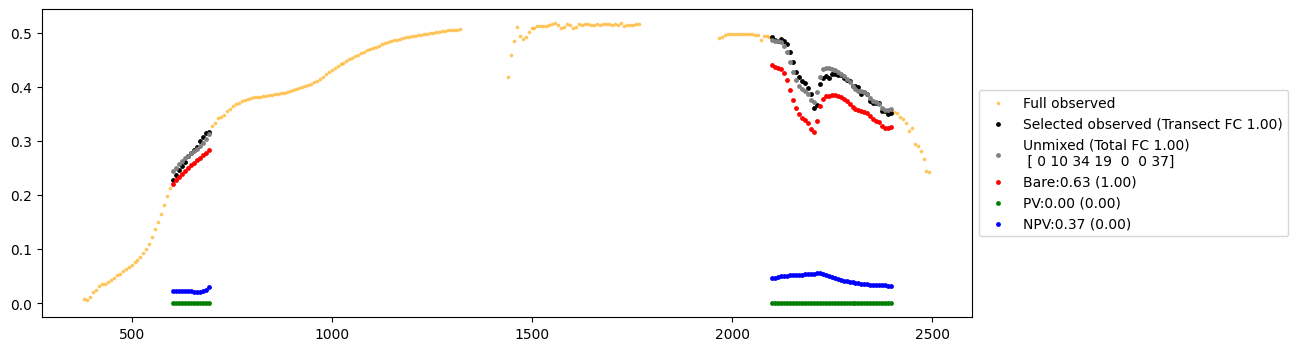

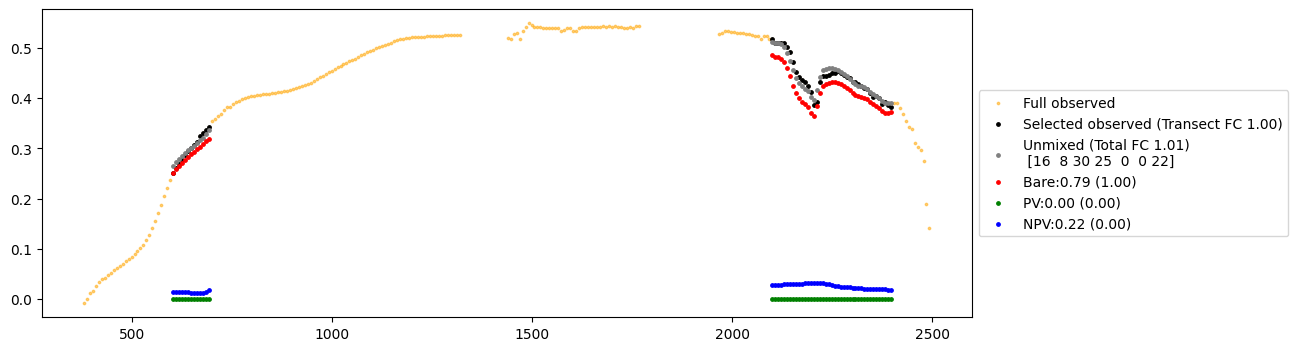

In [62]:
ranges_exclude = [(0, 440), (1310, 1490), (1770, 2050), (2440, 2880)]
ranges_exclude = [(0, 600), (1310, 1600), (1700, 2100), (2400, 2880)] # full range only works well for pure soil signals
# NIR + SWIR
ranges_exclude = [(0, 600), (700, 2100), (2400, 2880)]
# only SWIR
#ranges_exclude = [(0, 2100), (2400, 2880)]


true_values = []
estimated_values = []

for fid, df in transect_spectra.items():
    row =df_fc[df_fc['FID']==fid[0]]
    
    # Get the indices of the bands that fall outside the ranges
    df_filtered = df[[is_outside_range(round(wavelength), ranges_exclude) for wavelength in df.wavelengths]]
    df_filtered = df_filtered[~df_filtered.reflectance.isnull()]
    if len(df_filtered)==0: break
    true_values.append(tuple(row[['totalBareCover', 'totalPVCover','totalNPVCover']].values.flatten()))

    new_index = pd.Index(df_filtered.wavelengths, name='Wavelength')
    df_interp = endmembers_df.reindex(endmembers_df.index.union(new_index)).interpolate(method='linear').loc[new_index]

    fractions_nnls, fractions, fractions_bgd = unmix_nnls(df_filtered.reflectance.values[:, np.newaxis], df_interp.values.T, bare_green_dry)

    estimated_values.append(fractions_bgd.flatten()/100.)

    #print(row[['FID', 'obs_time','totalBareCover', 'totalPVCover','totalNPVCover']], fracs)
    print("fractions", fractions.flatten())
    
    E0 = df_interp.values
    A0 = fractions_nnls
    plt.figure(figsize=(12,4))
    unmixed = np.dot(A0.T, E0.T).T
    original_sum = np.sum(true_values[-1])
    estimated_sum = np.sum(estimated_values[-1])

    # full spec
    plt.scatter(df.wavelengths, df.reflectance, color='orange', label='Full observed', s=3, alpha=0.5)
    #plt.scatter(endmembers_df.index, np.dot(A0.T, endmembers_df.values.T).T,label='Mixed full spec', color='salmon', s=3, alpha=0.2)

    # fitted spec
    plt.scatter(df_filtered.wavelengths, df_filtered.reflectance, label=f'Selected observed (Transect FC {original_sum:.2f})', color='black', s=6)
    plt.scatter(df_filtered.wavelengths, unmixed, label=f'Unmixed (Total FC {estimated_sum:.2f}) \n {fractions.flatten()}', color='gray', s=6)
    c1 =np.dot(A0[bare_green_dry[0],:].T, E0[:,bare_green_dry[0]].T).T
    c2 =np.dot(A0[bare_green_dry[1],:].T, E0[:,bare_green_dry[1]].T).T
    c3 =np.dot(A0[bare_green_dry[2],:].T, E0[:,bare_green_dry[2]].T).T
    plt.scatter(df_filtered.wavelengths, c1, label=f'Bare:{estimated_values[-1][0]:.2f} ({true_values[-1][0]:.2f})', color='r', s=6)
    plt.scatter(df_filtered.wavelengths, c2, label=f'PV:{estimated_values[-1][1]:.2f} ({true_values[-1][1]:.2f})', color='g', s=6)
    plt.scatter(df_filtered.wavelengths, c3, label=f'NPV:{estimated_values[-1][2]:.2f} ({true_values[-1][2]:.2f})', color='b', s=6)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    

In [61]:
diff = np.array(true_values)-np.array(estimated_values)
rmse = np.sqrt(np.mean(diff ** 2, axis=0))
mae = np.mean(np.abs(diff), axis=0)
print(f"Bare: RMSE {rmse[0]:.2f}, MAE {mae[0]:.2f}")
print(f"PV: RMSE {rmse[1]:.2f}, MAE {mae[1]:.2f}")
print(f"NPV: RMSE {rmse[2]:.2f}, MAE {mae[2]:.2f}")

Bare: RMSE 0.16, MAE 0.12
PV: RMSE 0.05, MAE 0.04
NPV: RMSE 0.18, MAE 0.16


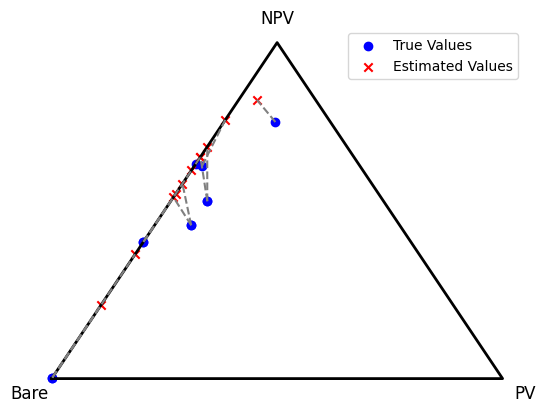

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Function to convert ternary (a, b, c) to 2D Cartesian (x, y)
def ternary_to_cartesian(a, b, c):
    x = 0.5 * (2 * b + c)  # Convert (a, b, c) to x
    y = (np.sqrt(3) / 2) * c  # Convert (a, b, c) to y
    return x, y

# Convert points to Cartesian coordinates
true_xy = np.array([ternary_to_cartesian(*point) for point in true_values])
estimated_xy = np.array([ternary_to_cartesian(*point) for point in estimated_values])

# Plot triangle boundary
triangle = np.array([[0, 0], [1, 0], [0.5, np.sqrt(3)/2], [0, 0]])  # Triangle vertices
plt.plot(triangle[:, 0], triangle[:, 1], "k-", linewidth=2)  # Plot boundary

# Scatter plots
plt.scatter(true_xy[:, 0], true_xy[:, 1], color="blue", marker="o", label="True Values")
plt.scatter(estimated_xy[:, 0], estimated_xy[:, 1], color="red", marker="x", label="Estimated Values")

# Draw lines connecting true and estimated points
for t, e in zip(true_xy, estimated_xy):
    plt.plot([t[0], e[0]], [t[1], e[1]], "gray", linestyle="dashed")

# Labels and title
plt.text(-0.05, -0.05, "Bare", fontsize=12, ha="center")
plt.text(1.05, -0.05, "PV", fontsize=12, ha="center")
plt.text(0.5, np.sqrt(3)/2 + 0.05, "NPV", fontsize=12, ha="center")

plt.legend()
plt.axis("off")  # Hide axis
plt.show()

